In [2]:
# !pip install scikit-image

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-09-13 08:17:31.046395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 08:17:34.769818: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-09-13 08:17:34.769996: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-09-13 08:17:34.774278: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-09-13 08:17:35.111740: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


# Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [3]:
image = load_img("./catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

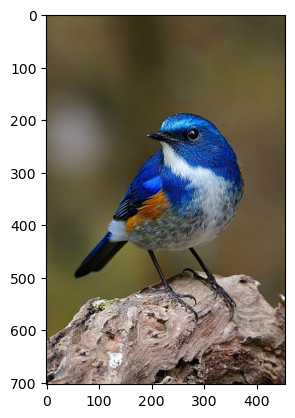

In [4]:
plt.imshow(image)
plt.show()

In [5]:
datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

In [6]:
image_array.reshape((1,) + image_array.shape).shape

(1, 703, 454, 3)

In [7]:
image_array.shape

(703, 454, 3)

In [8]:
image_array = image_array.reshape((1,) + image_array.shape)

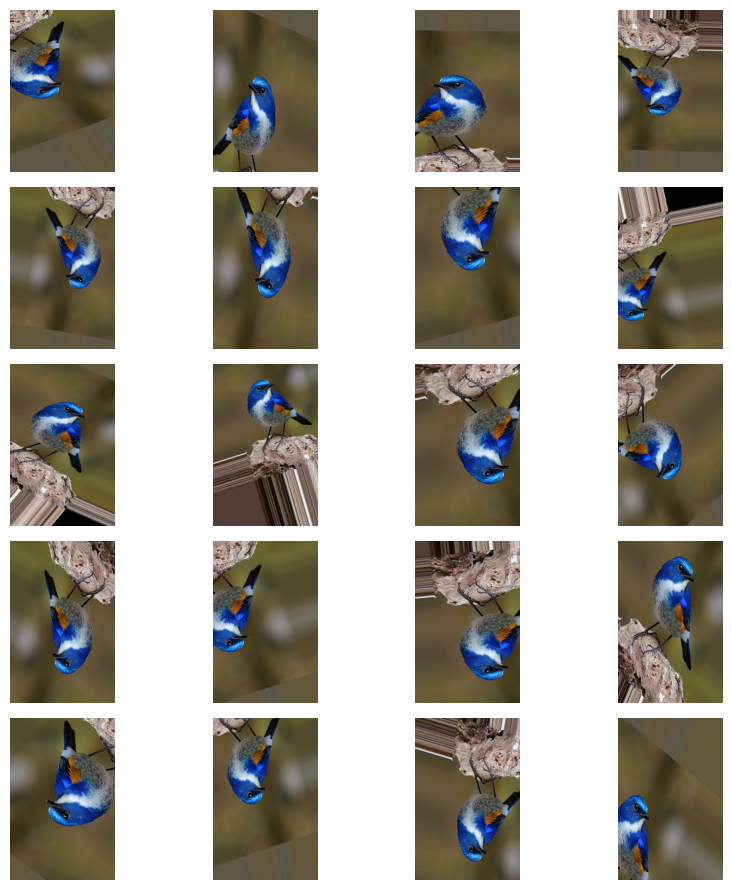

In [9]:
fig, axes = plt.subplots(5, 4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    if i >= 20:   # 20개 이미지 생성 후 종료
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 전이학습 
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 훈련하거나 결과를 출력

In [15]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152V2
import tensorflow as tf

# GPU 디바이스 설정
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [13]:
base_model = ResNet50(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

I0000 00:00:1726145635.470968    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.471038    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.471056    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.569317    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.569372    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-12

In [14]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(2, activation='sigmoid'))
# model.summary()

In [16]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet50_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [11]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [12]:
train = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [13]:
valid = ImageDataGenerator(rescale=1.0/255)
valid_gen = valid.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [20]:
history=model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726145646.678088    1944 service.cc:146] XLA service 0x7f35e8062840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726145646.678131    1944 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-12 12:54:06.770785: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-12 12:54:07.372150: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-09-12 12:5

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/step - accuracy: 0.4600 - loss: 0.6935

2024-09-12 12:54:20.522431: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 4 bytes spill stores, 4 bytes spill loads

2024-09-12 12:54:20.895751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 64 bytes spill stores, 64 bytes spill loads

2024-09-12 12:54:20.958234: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 184 bytes spill stores, 184 bytes spill loads

2024-09-12 12:54:21.123295: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 548 bytes spill stores, 376 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 22s/step - accuracy: 0.4685 - loss: 0.6934 - val_accuracy: 0.4727 - val_loss: 0.6932
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.4685 - loss: 0.6933 - val_accuracy: 0.4909 - val_loss: 0.6931
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.4789 - loss: 0.6931 - val_accuracy: 0.5273 - val_loss: 0.6931
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5315 - loss: 0.6930 - val_accuracy: 0.5273 - val_loss: 0.6930
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 8s/step - accuracy: 0.5353 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6929
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5298 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6928
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5482 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6927
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step - accuracy: 0.5182 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6927
Epoch

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5281 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 53/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5245 - loss: 0.6919 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 54/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.5382 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 55/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6918 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 56/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6913 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 57/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5137 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 58/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5448 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 59/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5191 - loss: 0.6924 - val_accuracy: 0.5273 - val_loss: 0.691

Epoch 103/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5415 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 104/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5155 - loss: 0.6927 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 105/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6912 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 106/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5317 - loss: 0.6910 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 107/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5215 - loss: 0.6921 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 108/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5348 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 109/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5191 - loss: 0.6923 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 110/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5173 - loss: 0.6925 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5298 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 204/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5335 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 205/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5155 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 206/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5245 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 207/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5173 - loss: 0.6924 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 208/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5137 - loss: 0.6927 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 209/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 210/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5209 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5382 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 304/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5407 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 305/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5317 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 306/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5232 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 307/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5137 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 308/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5282 - loss: 0.6910 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 309/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5332 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 310/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 10s/step - accuracy: 0.5209 - loss: 0.6918 - val_accuracy: 0.5273 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5232 - loss: 0.6912 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 404/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5165 - loss: 0.6921 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 405/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5335 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 406/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5209 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 407/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5317 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 408/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5335 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 409/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5119 - loss: 0.6928 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 410/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5198 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5148 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 504/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5332 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 505/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5389 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 506/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 507/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5173 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 508/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5048 - loss: 0.6930 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 509/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5282 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 510/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5232 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5148 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 604/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5407 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 605/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5348 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 606/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 607/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5132 - loss: 0.6921 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 608/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 609/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5263 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 610/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5263 - loss: 0.6909 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5119 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 704/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5398 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 705/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5389 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 706/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5227 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 707/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5299 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 708/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5227 - loss: 0.6909 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 709/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5398 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 710/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6901 - val_accuracy: 0.5273 - val_lo

2024-09-12 15:20:00.390640: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5311 - loss: 0.6894

2024-09-12 15:20:02.369775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.5298 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 743/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 14s/step - accuracy: 0.5155 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 744/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5298 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 745/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5353 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 746/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 747/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5263 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 748/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5198 - loss: 0.6913 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 749/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 26s/step - accuracy: 0.5407 - loss: 0.6885 - val_accuracy: 0.5273 - va

2024-09-12 15:26:53.765886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 111392200 bytes after encountering the first element of size 111392200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5371 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 770/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5248 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 771/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5298 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 772/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5245 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 773/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5182 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 774/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 775/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5282 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 776/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5215 - loss: 0.6908 - val_accuracy: 0.5273 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5115 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 870/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5365 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 871/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5281 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 872/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5215 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 873/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5191 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 874/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5215 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 875/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5165 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6891
Epoch 876/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5382 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5371 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 970/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5332 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 971/2000


2024-09-12 16:08:29.207166: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5336 - loss: 0.6890

2024-09-12 16:08:31.199497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 972/2000


2024-09-12 16:08:41.847413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5186 - loss: 0.6898

2024-09-12 16:08:43.724508: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5215 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 973/2000


2024-09-12 16:08:54.110142: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 111392200 bytes after encountering the first element of size 111392200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5366 - loss: 0.6883

2024-09-12 16:08:56.012198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5335 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 974/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5248 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 975/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 976/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5332 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 977/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 978/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5365 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 979/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5415 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 980/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5382 - loss: 0.6884 - val_accuracy: 0.5273 - val_loss

2024-09-12 16:14:34.011444: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5248 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1002/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5299 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1003/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5365 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1004/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5282 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1005/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5065 - loss: 0.6919 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1006/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5365 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1007/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5245 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1008/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5479 - loss: 0.6877 - val_accuracy: 0.5273 - v

2024-09-12 16:16:53.223133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5211 - loss: 0.6902

2024-09-12 16:16:55.018700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5232 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1013/2000


2024-09-12 16:17:05.686905: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1014/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5353 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1015/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5443 - loss: 0.6877 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1016/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5155 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1017/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5353 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1018/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5248 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1019/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5065 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1020/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5317 - loss: 0.6898 - val_accuracy: 0.5273 - v

2024-09-12 16:25:53.179443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:25:53.180747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 33s/step - accuracy: 0.5132 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1052/2000


2024-09-12 16:26:37.793340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:26:37.795023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 20s/step - accuracy: 0.5432 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1053/2000


2024-09-12 16:27:09.844390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:27:09.845410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 35s/step - accuracy: 0.5382 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1054/2000


2024-09-12 16:27:56.855899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:27:56.857080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 48s 36s/step - accuracy: 0.5198 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1055/2000


2024-09-12 16:28:46.482299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:28:46.483645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 31s/step - accuracy: 0.5298 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1056/2000


2024-09-12 16:29:30.553224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:29:30.554974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 31s/step - accuracy: 0.5215 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1057/2000


2024-09-12 16:30:15.345869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:30:15.347263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 29s/step - accuracy: 0.5415 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1058/2000


2024-09-12 16:30:55.523078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:30:55.524496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 27s/step - accuracy: 0.5198 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1059/2000


2024-09-12 16:31:36.867477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:31:36.869095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 63s 49s/step - accuracy: 0.5315 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1060/2000


2024-09-12 16:32:41.793703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:32:41.794882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 29s/step - accuracy: 0.5389 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1061/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 8s/step - accuracy: 0.5198 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1062/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5281 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1063/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5248 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1064/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5191 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1065/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5265 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1066/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5348 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1067/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5299 - loss: 0.6890 - val_accuracy: 0.5273 - 

2024-09-12 16:38:37.610822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:38:37.612289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.5265 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1081/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5407 - loss: 0.6878 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1082/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5332 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1083/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5335 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1084/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5415 - loss: 0.6884 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1085/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.5165 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1086/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 11s/step - accuracy: 0.5245 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1087/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 17s/step - accuracy: 0.5232 - loss: 0.6902 - val_accuracy: 0.5273 -

2024-09-12 16:40:40.927415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:40:40.928888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 50s/step - accuracy: 0.5317 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1089/2000


2024-09-12 16:41:48.668711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:41:48.669623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.5448 - loss: 0.6880 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1090/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5398 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1091/2000


2024-09-12 16:42:18.664832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:42:18.666311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 41s/step - accuracy: 0.5332 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1092/2000


2024-09-12 16:43:18.311537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:43:18.312646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 51s/step - accuracy: 0.5232 - loss: 0.6898 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1093/2000


2024-09-12 16:44:20.153662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 8
2024-09-12 16:44:22.811827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 32s/step - accuracy: 0.5335 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1094/2000


2024-09-12 16:45:07.005378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:45:07.007009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 45s/step - accuracy: 0.5265 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1095/2000


2024-09-12 16:46:06.206700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:46:06.208196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 31s/step - accuracy: 0.5317 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1096/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5232 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1097/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5335 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1098/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1099/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5191 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1100/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5173 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1101/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5263 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1102/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5137 - loss: 0.6910 - val_accuracy: 0.5273 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5132 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1196/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5148 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1197/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5263 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1198/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5245 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1199/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5245 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1200/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5443 - loss: 0.6869 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1201/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1202/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5265 - loss: 0.6896 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5263 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1296/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5352 - loss: 0.6874 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1297/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5232 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1298/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5227 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1299/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5173 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6879
Epoch 1300/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5298 - loss: 0.6888 - val_accuracy: 0.5273 - val_loss: 0.6879
Epoch 1301/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5407 - loss: 0.6874 - val_accuracy: 0.5273 - val_loss: 0.6879
Epoch 1302/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5335 - loss: 0.6886 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1396/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5317 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1397/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5148 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1398/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5371 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1399/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5365 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1400/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5227 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1401/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5248 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1402/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5415 - loss: 0.6872 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.5298 - loss: 0.6881 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1496/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1497/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5226 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1498/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5227 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1499/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5173 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1500/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5382 - loss: 0.6873 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1501/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5281 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1502/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6887 - val_accuracy: 0.5273 - v

2024-09-12 18:20:12.733343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 18:20:12.734789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 8s/step - accuracy: 0.5208 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1561/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5132 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1562/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5173 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1563/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5245 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1564/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5173 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1565/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5315 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1566/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5182 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1567/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5191 - loss: 0.6904 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5389 - loss: 0.6870 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1661/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5317 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1662/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1663/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5226 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1664/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5173 - loss: 0.6888 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1665/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5416 - loss: 0.6872 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1666/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5244 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1667/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5173 - loss: 0.6896 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5382 - loss: 0.6875 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1761/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5298 - loss: 0.6882 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1762/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5280 - loss: 0.6886 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1763/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5232 - loss: 0.6884 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1764/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5245 - loss: 0.6889 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1765/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5352 - loss: 0.6868 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1766/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5442 - loss: 0.6867 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1767/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5165 - loss: 0.6899 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5262 - loss: 0.6889 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1861/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5399 - loss: 0.6872 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1862/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5245 - loss: 0.6887 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1863/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5209 - loss: 0.6894 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1864/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6866 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1865/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6885 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1866/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5137 - loss: 0.6894 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1867/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5264 - loss: 0.6885 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5317 - loss: 0.6871 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1961/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5352 - loss: 0.6881 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1962/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5316 - loss: 0.6876 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1963/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5315 - loss: 0.6871 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1964/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5244 - loss: 0.6888 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1965/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5299 - loss: 0.6879 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1966/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5334 - loss: 0.6878 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1967/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5282 - loss: 0.6878 - val_accuracy: 0.5299 - v

# Resnet

In [16]:
base_model2 = ResNet152V2(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

2024-09-13 08:18:51.021850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 08:18:51.023379: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon(TM) RX Vega 11 Graphics)
2024-09-13 08:18:51.139029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 08:18:51.139093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


242745792/242745792 [==============================] - 10s 0us/step


In [17]:
base_model2.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_blo

                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
          

 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
          

                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)

                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block33_2_relu[0][0]']   
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
          

In [18]:
base_model2.trainable = False
model2 = Sequential()
model2.add(base_model2)
model2.add(Dense(2, activation='sigmoid'))
# model.summary()

In [19]:
model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet152V2_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [20]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [ ]:
history2=model2.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


2024-09-13 08:19:28.853561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 08:19:30.792065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 08:19:30.792129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.6545 

2024-09-13 08:19:50.364584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 08:19:51.569264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 08:19:51.569334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - 48s 27s/step - loss: 0.6911 - accuracy: 0.6545 - val_loss: 0.6906 - val_accuracy: 0.6987
Epoch 2/2000
2/2 [==============================] - 35s 27s/step - loss: 0.6911 - accuracy: 0.6338 - val_loss: 0.6897 - val_accuracy: 0.7169
Epoch 3/2000
2/2 [==============================] - 35s 25s/step - loss: 0.6908 - accuracy: 0.6390 - val_loss: 0.6889 - val_accuracy: 0.7351
Epoch 4/2000
2/2 [==============================] - 36s 25s/step - loss: 0.6899 - accuracy: 0.6701 - val_loss: 0.6881 - val_accuracy: 0.7403
Epoch 5/2000
2/2 [==============================] - 34s 25s/step - loss: 0.6890 - accuracy: 0.7013 - val_loss: 0.6873 - val_accuracy: 0.7558
Epoch 6/2000
2/2 [==============================] - 36s 27s/step - loss: 0.6889 - accuracy: 0.7039 - val_loss: 0.6865 - val_accuracy: 0.8026
Epoch 7/2000
2/2 [==============================] - 34s 24s/step - loss: 0.6883 - accuracy: 0.6909 - val_loss: 0.6857 - val_accuracy: 0.8182
Epoch 8/2000
2/2 [========

Epoch 59/2000
2/2 [==============================] - 35s 25s/step - loss: 0.6585 - accuracy: 0.8130 - val_loss: 0.6465 - val_accuracy: 0.9247
Epoch 60/2000
2/2 [==============================] - 35s 26s/step - loss: 0.6583 - accuracy: 0.7974 - val_loss: 0.6458 - val_accuracy: 0.9247
Epoch 61/2000
2/2 [==============================] - 35s 25s/step - loss: 0.6594 - accuracy: 0.8078 - val_loss: 0.6451 - val_accuracy: 0.9247
Epoch 62/2000
2/2 [==============================] - 35s 26s/step - loss: 0.6606 - accuracy: 0.7714 - val_loss: 0.6445 - val_accuracy: 0.9247
Epoch 63/2000
2/2 [==============================] - 36s 26s/step - loss: 0.6574 - accuracy: 0.7792 - val_loss: 0.6438 - val_accuracy: 0.9247
Epoch 64/2000
2/2 [==============================] - 37s 27s/step - loss: 0.6569 - accuracy: 0.7948 - val_loss: 0.6431 - val_accuracy: 0.9247
Epoch 65/2000
2/2 [==============================] - 39s 27s/step - loss: 0.6564 - accuracy: 0.8156 - val_loss: 0.6424 - val_accuracy: 0.9247
Epoch 

2/2 [==============================] - 43s 31s/step - loss: 0.6307 - accuracy: 0.8312 - val_loss: 0.6077 - val_accuracy: 0.9325
Epoch 117/2000
2/2 [==============================] - 42s 30s/step - loss: 0.6268 - accuracy: 0.8649 - val_loss: 0.6071 - val_accuracy: 0.9325
Epoch 118/2000
2/2 [==============================] - 41s 31s/step - loss: 0.6295 - accuracy: 0.8260 - val_loss: 0.6064 - val_accuracy: 0.9325
Epoch 119/2000
2/2 [==============================] - 45s 33s/step - loss: 0.6305 - accuracy: 0.8286 - val_loss: 0.6057 - val_accuracy: 0.9325
Epoch 120/2000
2/2 [==============================] - 45s 33s/step - loss: 0.6307 - accuracy: 0.8234 - val_loss: 0.6051 - val_accuracy: 0.9325
Epoch 121/2000
2/2 [==============================] - 43s 32s/step - loss: 0.6283 - accuracy: 0.8260 - val_loss: 0.6045 - val_accuracy: 0.9325
Epoch 122/2000
2/2 [==============================] - 44s 31s/step - loss: 0.6277 - accuracy: 0.8338 - val_loss: 0.6038 - val_accuracy: 0.9325
Epoch 123/2000

2/2 [==============================] - 49s 38s/step - loss: 0.6056 - accuracy: 0.8156 - val_loss: 0.5720 - val_accuracy: 0.9455
Epoch 174/2000
2/2 [==============================] - 40s 29s/step - loss: 0.6016 - accuracy: 0.8468 - val_loss: 0.5714 - val_accuracy: 0.9455
Epoch 175/2000
2/2 [==============================] - 37s 27s/step - loss: 0.5995 - accuracy: 0.8571 - val_loss: 0.5708 - val_accuracy: 0.9455
Epoch 176/2000
2/2 [==============================] - 49s 38s/step - loss: 0.6013 - accuracy: 0.8494 - val_loss: 0.5702 - val_accuracy: 0.9455
Epoch 177/2000
2/2 [==============================] - 41s 28s/step - loss: 0.6038 - accuracy: 0.8338 - val_loss: 0.5696 - val_accuracy: 0.9455
Epoch 178/2000
2/2 [==============================] - 41s 30s/step - loss: 0.5986 - accuracy: 0.8494 - val_loss: 0.5690 - val_accuracy: 0.9455
Epoch 179/2000
2/2 [==============================] - 41s 30s/step - loss: 0.5947 - accuracy: 0.8857 - val_loss: 0.5684 - val_accuracy: 0.9455
Epoch 180/2000

2/2 [==============================] - 36s 26s/step - loss: 0.5794 - accuracy: 0.8571 - val_loss: 0.5389 - val_accuracy: 0.9558
Epoch 231/2000
2/2 [==============================] - 36s 25s/step - loss: 0.5813 - accuracy: 0.8545 - val_loss: 0.5383 - val_accuracy: 0.9558
Epoch 232/2000
2/2 [==============================] - 35s 25s/step - loss: 0.5850 - accuracy: 0.8442 - val_loss: 0.5378 - val_accuracy: 0.9558
Epoch 233/2000
2/2 [==============================] - 36s 27s/step - loss: 0.5839 - accuracy: 0.8286 - val_loss: 0.5372 - val_accuracy: 0.9558
Epoch 234/2000
2/2 [==============================] - 35s 26s/step - loss: 0.5853 - accuracy: 0.8468 - val_loss: 0.5367 - val_accuracy: 0.9558
Epoch 235/2000
2/2 [==============================] - 37s 27s/step - loss: 0.5785 - accuracy: 0.8519 - val_loss: 0.5362 - val_accuracy: 0.9558
Epoch 236/2000
2/2 [==============================] - 36s 26s/step - loss: 0.5773 - accuracy: 0.8649 - val_loss: 0.5356 - val_accuracy: 0.9558
Epoch 237/2000

2/2 [==============================] - 70s 55s/step - loss: 0.5581 - accuracy: 0.8675 - val_loss: 0.5088 - val_accuracy: 0.9584
Epoch 288/2000
2/2 [==============================] - 74s 55s/step - loss: 0.5605 - accuracy: 0.8753 - val_loss: 0.5082 - val_accuracy: 0.9584
Epoch 289/2000
2/2 [==============================] - 75s 54s/step - loss: 0.5609 - accuracy: 0.8468 - val_loss: 0.5077 - val_accuracy: 0.9584
Epoch 290/2000
2/2 [==============================] - 62s 41s/step - loss: 0.5550 - accuracy: 0.8545 - val_loss: 0.5072 - val_accuracy: 0.9584
Epoch 291/2000
2/2 [==============================] - 45s 32s/step - loss: 0.5519 - accuracy: 0.8701 - val_loss: 0.5067 - val_accuracy: 0.9610
Epoch 292/2000
2/2 [==============================] - 45s 34s/step - loss: 0.5538 - accuracy: 0.8597 - val_loss: 0.5062 - val_accuracy: 0.9610
Epoch 293/2000
2/2 [==============================] - 56s 36s/step - loss: 0.5527 - accuracy: 0.8727 - val_loss: 0.5057 - val_accuracy: 0.9610
Epoch 294/2000